In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.core.display import Image
from sklearn.model_selection import train_test_split
from torchvision import models
from torch.utils.data import Dataset, DataLoader, default_collate
import numpy as np
import pandas as pd
import os
import cv2 as cv
from torchvision.transforms import AutoAugmentPolicy, InterpolationMode


In [134]:
#train_folder = r"/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train"
train_folder = r"C:/Users/alito/OneDrive/Desktop/Dersler/Computer_Vision/Group_Assignment2/train"

# preprocess
train_df = pd.read_csv(os.path.join(train_folder, 'train_set.csv'), index_col="Id")
labels_cols = list(train_df.columns)
train_df["img"] = [np.load(os.path.join(train_folder, 'img/train_{}.npy'.format(idx))) for idx, _ in train_df.iterrows()]

all_labled_X = train_df.loc[:, ["img"]]
all_labled_Y = train_df.loc[:, labels_cols]

X_train, X_test, y_train, y_test = train_test_split(all_labled_X, all_labled_Y, test_size=0.2, random_state=100)

XY_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
XY_test = pd.merge(X_test, y_test, left_index=True, right_index=True)
print(y_test.shape)
print(X_test.shape)

(150, 20)
(150, 1)


In [3]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

C:\Users\alito\anaconda3\envs\computervision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [122]:
def classify_one_image(image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.9
    #print([image.shape[::-1][1:]])
    target_sizes = torch.tensor([image.shape[::-1][1:]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
    lbls = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
#         box = [round(i, 2) for i in box.tolist()]
        lbls.append(model.config.id2label[label.item()])
        #print(
        #        f"Detected {model.config.id2label[label.item()]} with confidence "
        #        f"{round(score.item(), 3)} at location {box}"
        #)
    return set(lbls)

def create_lbl_array(lbls, labels_cols):
    labels_cols = labels_cols.copy()
    labels_cols[0] = "airplane"
    labels_cols[10] = "dining table"
    labels_cols[13] = "motorcycle"
    labels_cols[15] = "potted plant"
    labels_cols[19] = "tv"
    out = np.zeros_like(labels_cols, dtype=np.uint8)
    for i in range(len(labels_cols)):
        if labels_cols[i] in lbls:
            out[i] = 1
    return out

In [32]:
def array_to_labels(x):
    for i in range(len(x)):
        is_label = int(x[i])
        if is_label:
            print(labels_cols[i])

def timshow(x):
    plt.imshow(transforms.ToPILImage()(x))

# dataloader
class ImagesDataset(Dataset):
    def __init__(self, dataframe, transform=None, img_col="img", label_cols=labels_cols):
        """
        :param dataframe: dataframe with column named "img" containing the image
        """
        self.df = dataframe
        self.transform = transform
        self.img_col = img_col
        self.label_cols = labels_cols

    def __getitem__(self, item):
        img = self.df.iloc[item][self.img_col]
        labels = np.array(list(self.df.iloc[item][self.label_cols]), dtype=np.float32)
        if self.transform:
            img = self.transform(img)
            # checking if the retruend images are batched
            if len(img.shape) == 4:
                # return batched labels as well
                labels = np.tile(labels, img.shape[0]).reshape(img.shape[0], -1)
        return img, labels

    def __len__(self):
        # note the len only returns the number of raw images but not the augmented ones!!
        return len(self.df)


In [7]:
print(labels_cols)

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


[(500, 375)]


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

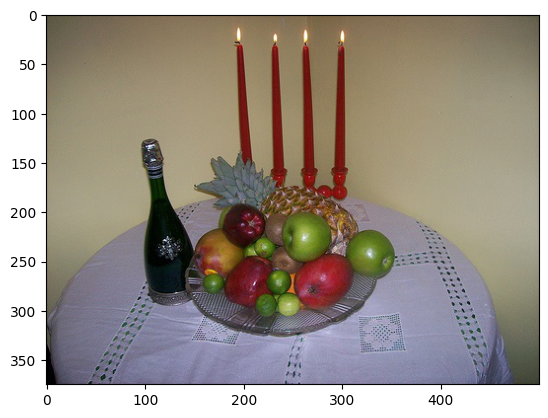

In [8]:
im = XY_test.iloc[10]['img']
plt.imshow(im)
lbls = classify_one_image(im)
create_lbl_array(lbls, labels_cols)

In [9]:
batch_size = 1
train_XY_dataset = ImagesDataset(XY_train, lable_cols=labels_cols)
train_XY_dataloader = DataLoader(dataset=train_XY_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)


test_XY_dataset = ImagesDataset(XY_test, lable_cols=labels_cols)
test_XY_dataloader = DataLoader(dataset=test_XY_dataset, batch_size=batch_size, shuffle=False,  collate_fn=lambda x: x)


In [ ]:
    dataloader = test_XY_dataloader
# def eval_model(model, dataloader ):
    # evaluation
    true_lables = []
    predicted_lables =[]
    pred_images = []

    print("start eval")
    with torch.no_grad():
        
        for i,data  in enumerate(dataloader):
            data = np.array(data, dtype=object)
            images = data[:, 0]
            labels = data[:, 1]
            images = images[0]
            labels = labels[0]

            lbls = classify_one_image(images)
            pred = create_lbl_array(lbls, labels_cols)
            # if in cuda, remove from it so it will be possible to call numpy
#             if outputs.is_cuda:
#                 outputs = outputs.cpu()
#             if lables.is_cuda:
#                 lables = lables.cpu()
                
            predicted_lables.append(pred)
            true_lables.append(labels)
            pred_images.append(images)
            
            
    #
    # x = 144
    # plt.imshow(transforms.ToPILImage()(pred_images[x]))
    # array_to_lables(predicted_lables[x])
    # array_to_lables(true_lables[x])

    exact_match = 0
    for i in range(len(true_lables)):
        if np.array_equal(predicted_lables[i], true_lables[i]):
#             print(i)
#             print(array_to_lables(predicted_lables[i]))
            exact_match +=1
        else:
            print(i)
    print(f"MODEL EVAL exact match {exact_match}/{len(predicted_lables)}")


# Adversarial Attack

In the previous part, we have evaluated our classifier's performance for the test set. Now, we will write a function to perturb an image, and try to change the accurate guesses of our classifier!

To achieve this, we are using the Fast Gradient Sign Method. The method first calculates the probabilities for each class like a normal classifier. Then, the loss function is calculated between the probabilities and the labels. However, instead of calculating the loss for the true labels, we are calculating the loss for a target class of our choice to conduct the attack. The gradients are calculated through the backpropagation of loss with respect to the image. The gradient values show how much each pixel contributes to the loss. We use the sign of the gradients to generate a perturbation towards maximizing the loss. The signs are multiplied by epsilon, which is the step size. The epsilon allows us to control and fine tune the amount of perturbation. After adding $\epsilon * sign(grad)$ to the image, we have our perturbed image where the image is misclassified and the perturbation is not visible to the human eye.

We can adjust the epsilon to change the image in a smaller or more aggresive manner. We can also apply the perturbation function multiple times to apply smaller changes consistently to shift the gradient (and hence the class predictions) to the direction we want.

In [113]:
def perturb_image(image, target_class=0, epsilon=0.01):
    
    # Convert the image to a tensor
    image_tensor = processor(images=np.copy(image), return_tensors="pt")

    # Set the requires_grad attribute of the image tensor
    image_tensor['pixel_values'].requires_grad = True

    # Forward pass to obtain the model's predictions
    outputs = model(**image_tensor)

    # Get the predicted labels
    predicted_labels = classify_one_image(image)

    # Calculate the prediction scores (We also thought of calculating the maximum probability prediction for each bounding box to reduce dimensionality and obtain a potentially faster implementation)
    prediction_scores = outputs.logits[0]
    #prediction_scores = torch.max(outputs.logits[0], axis=0).values

    # Create the surrogate target tensor
    surrogate_target = torch.zeros_like(prediction_scores)
    #surrogate_target[target_class] = 1.0
    
    #for label in predicted_labels:
    #    label_id = model.config.label2id[label]
    #    surrogate_target[label_id] = 1.0

    
    # Calculate the loss by minimizing the confidence on the predicted class
    #target_loss = -predicted_probs[0, target_class]
    #print(target_loss)
    #target_loss2 = -predicted_probs[0, predicted_labels]
    #print(target_loss2)

    # Calculate the loss using cross-entropy
    loss = torch.nn.functional.binary_cross_entropy_with_logits(prediction_scores, surrogate_target)

    # Perform backpropagation to compute gradients
    # First, reset the existing gradient values in the model
    model.zero_grad()

    # Then, calculate gradients of model in backward/backpropagating pass
    loss.backward()
    grads = image_tensor['pixel_values'].grad.data
    #grads = torch.autograd.grad(loss, image_tensor['pixel_values'])[0]

    # Calculate the sign of the gradients
    sign_grad = grads.sign()
    #sign_grad = image_tensor.grad.sign()

    # Unnormalize the preprocessed image, to obtain back the original image and 
    # and add the gradient (perturbation) 
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

    inv_im = invTrans(image_tensor['pixel_values'])

    # Generate the perturbed image by adding the signed gradients
    perturbed_image = inv_im + epsilon * sign_grad

    # Clamp the pixel values to the valid range [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Convert the perturbed image tensor back to a PIL Image
    perturbed_image = transforms.ToPILImage()(perturbed_image.detach().squeeze(0))

    return perturbed_image

Here, we can see an image that was correctly classified before, but however is misclassified (or not classified at all) after the perturbation

[(500, 375)]
Label list:  ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
[(500, 375)]
Original Labels:  [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[(1066, 800)]
Perturbed Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


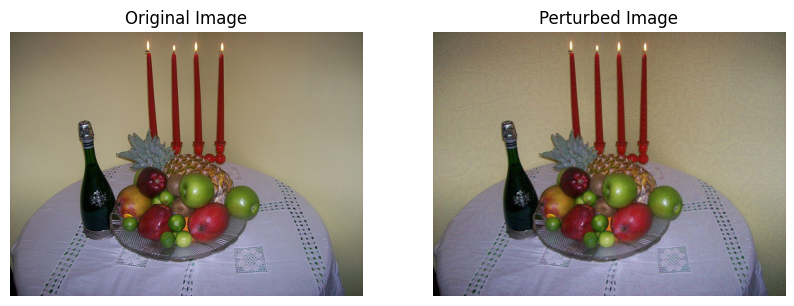

In [116]:
im = XY_test.iloc[10]['img']
perturbed_im = perturb_image(im, epsilon=0.02)
perturbed_im = np.array(perturbed_im)

print("Label list: ", labels_cols)

original_labels = classify_one_image(im)
original_labels = create_lbl_array(original_labels, labels_cols)
print("Original Labels: ", original_labels)

perturbed_labels = classify_one_image(perturbed_im)
perturbed_labels = create_lbl_array(perturbed_labels, labels_cols)
print("Perturbed Labels: ", perturbed_labels)

fig, axs = plt.subplots(1, 2, figsize=(10,10))

# Plot the first image
axs[0].imshow(im)
axs[0].axis('off')
axs[0].set_title('Original Image')

# Plot the second image
axs[1].imshow(perturbed_im)
axs[1].axis('off')
axs[1].set_title('Perturbed Image')

# Adjust spacing between subplots
#plt.tight_layout()

# Display the plot
plt.show()


The model we use for the classifier was not consistent unfortunately, so in case there was a problem (or not a problem) in the above cell when you run it; here's how the output looked like during our execution!

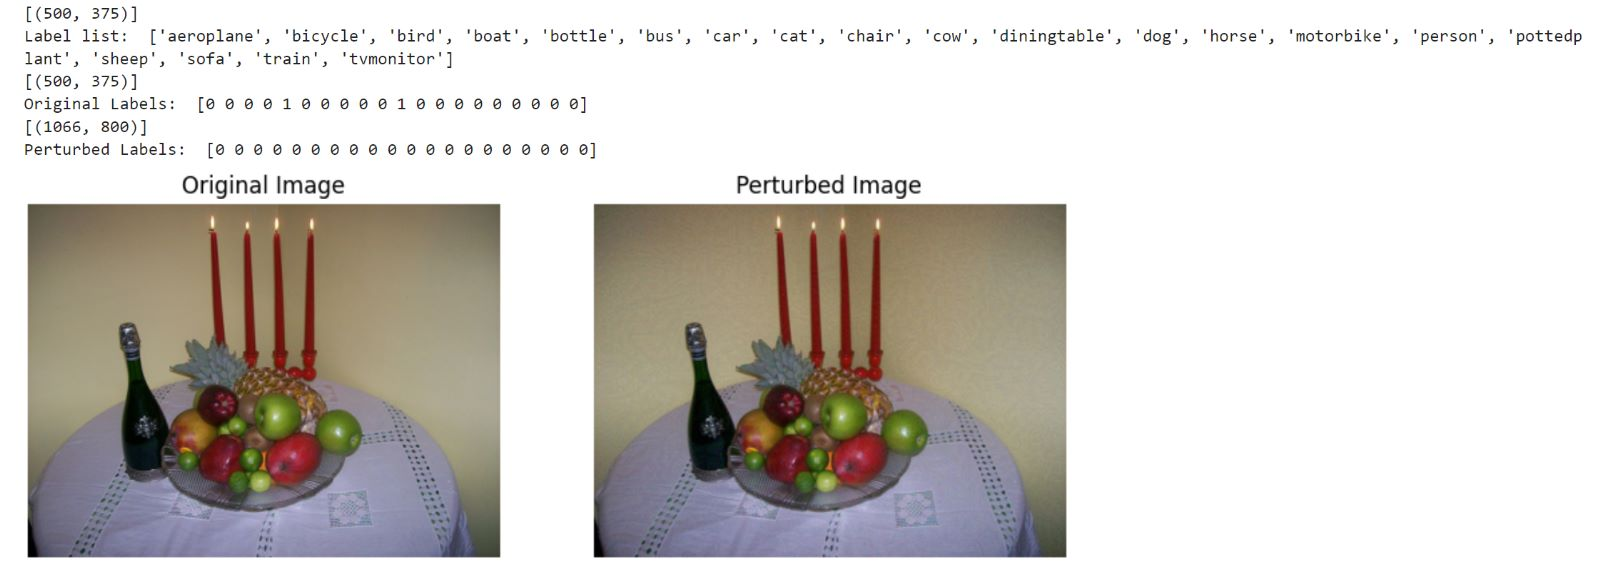

Of course, one image is not enough to conclude and we are going try our attack with all the dataset to measure the success of our attack.

One note is that this is a white-box attack, where we know about the underlying model and keep track of the gradient values. 

Another note is that we can use different methods to calculate the loss function.  

Successful Perturbation
True Labels:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Perturbed Labels:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


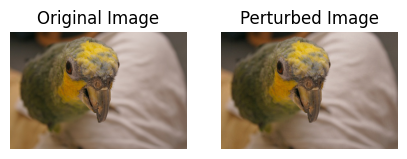

Image  110
Image  111
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]


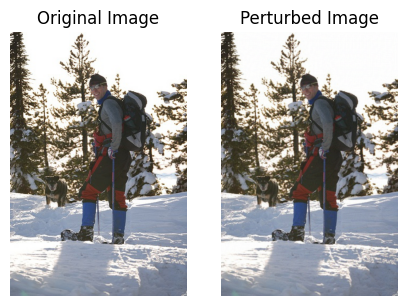

Image  112
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]


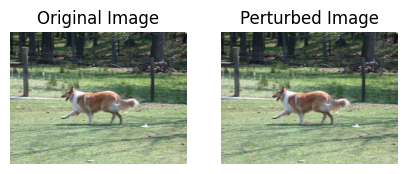

Image  113
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0]


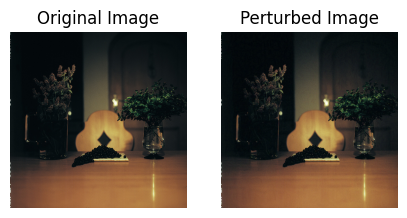

Image  114
Image  115
Image  116
Image  117
Image  118
Successful Perturbation
True Labels:  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
Perturbed Labels:  [0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0]


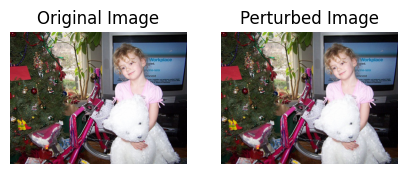

Image  119
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


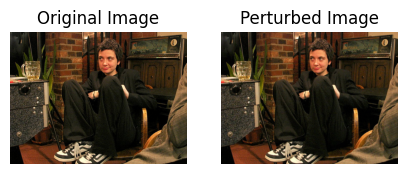

Image  120
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0]


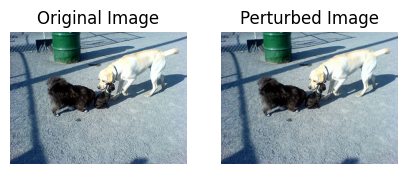

Image  121
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


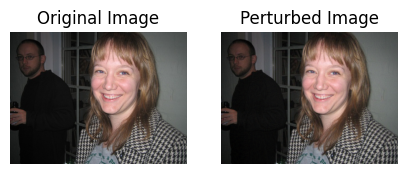

Image  122
Image  123
Successful Perturbation
True Labels:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Perturbed Labels:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


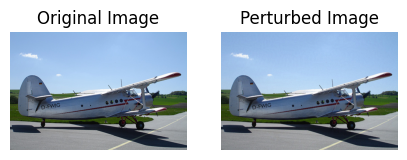

Image  124
Image  125
Image  126
Image  127
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0]


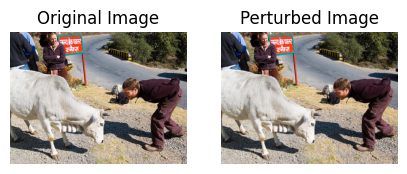

Image  128
Image  129
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


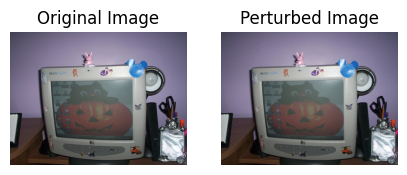

Image  130
Successful Perturbation
True Labels:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Perturbed Labels:  [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


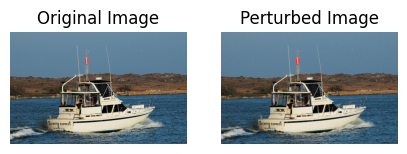

Image  131
Successful Perturbation
True Labels:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


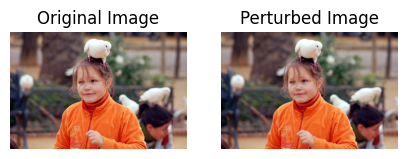

Image  132
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


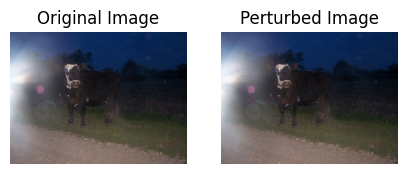

Image  133
Successful Perturbation
True Labels:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


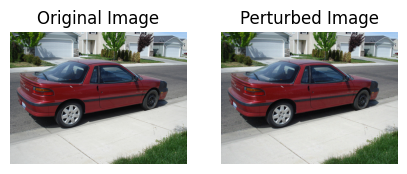

Image  134
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


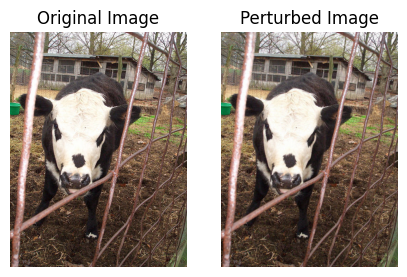

Image  135
Image  136
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]


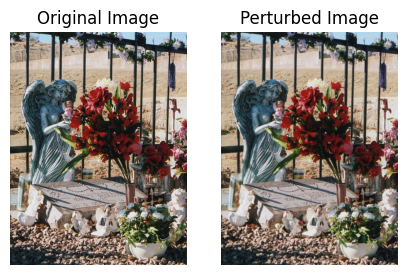

Image  137
Image  138
Image  139
Successful Perturbation
True Labels:  [0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0]
Perturbed Labels:  [0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0]


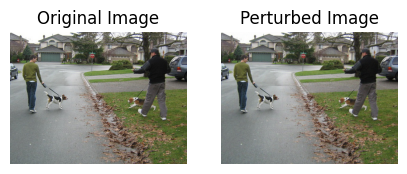

Image  140
Image  141
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


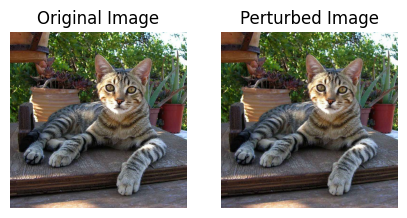

Image  142
Successful Perturbation
True Labels:  [0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0]


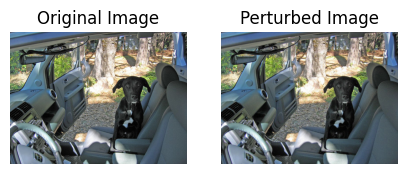

Image  143
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


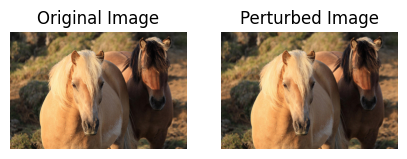

Image  144
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0]


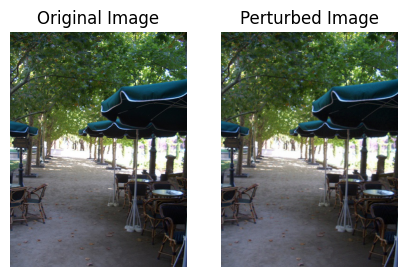

Image  145
Image  146
Successful Perturbation
True Labels:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Perturbed Labels:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


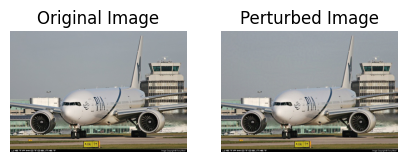

Image  147
Successful Perturbation
True Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0]


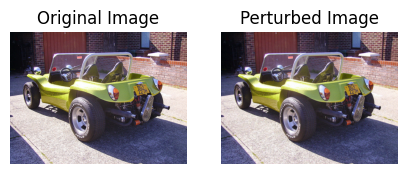

Image  148
Image  149
Successful attacks:  0.6


In [131]:
dataloader = test_XY_dataloader

print("Label list: ", labels_cols)

successful_attacks = 0
for i, data  in enumerate(dataloader):
    data = np.array(data, dtype=object)
    image = data[:, 0]
    label = data[:, 1]
    image = image[0]
    label = label[0]

    labels = classify_one_image(image)
    predicted_labels = create_lbl_array(labels, labels_cols)
            
    perturbed_image = np.array(perturb_image(image))
    
    labels = classify_one_image(perturbed_image)
    perturbed_labels = create_lbl_array(labels, labels_cols)
            
    if not np.array_equal(predicted_labels, perturbed_labels):
        print("Successful Perturbation")
        print("True Labels: " , (predicted_labels))
        print("Perturbed Labels: " , (perturbed_labels))

        fig, axs = plt.subplots(1, 2, figsize=(5,5))

        # Plot the first image
        axs[0].imshow(image)
        axs[0].axis('off')
        axs[0].set_title('Original Image')
        
        # Plot the second image
        axs[1].imshow(perturbed_image)
        axs[1].axis('off')
        axs[1].set_title('Perturbed Image')
        
        # Adjust spacing between subplots
        #plt.tight_layout()
        
        # Display the plot
        plt.show()

        successful_attacks += 1
    print("Image ", i)

print("Successful attacks: ", successful_attacks / len(dataloader))

Label list:  ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
Original Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Perturbed Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


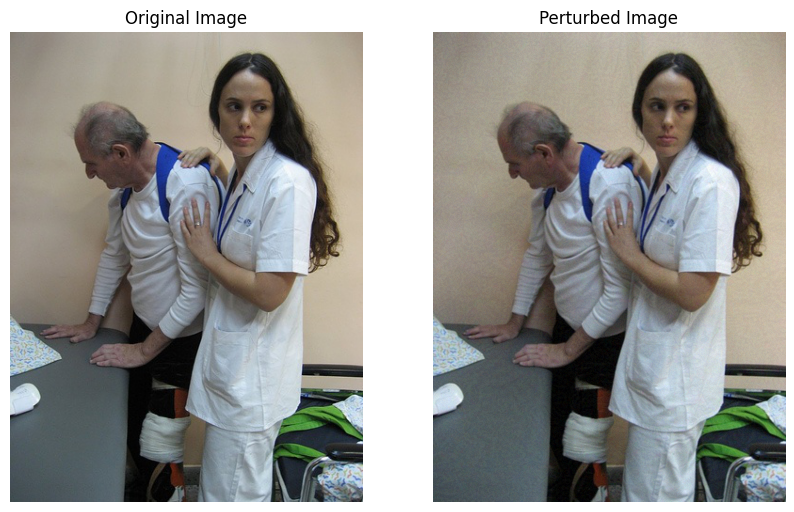

In [125]:
im = XY_test.iloc[7]['img']
perturbed_im = perturb_image(im, epsilon=0.02)
perturbed_im = np.array(perturbed_im)

print("Label list: ", labels_cols)

original_labels = classify_one_image(im)
original_labels = create_lbl_array(original_labels, labels_cols)
print("Original Labels: ", original_labels)

perturbed_labels = classify_one_image(perturbed_im)
perturbed_labels = create_lbl_array(perturbed_labels, labels_cols)
print("Perturbed Labels:", perturbed_labels)

fig, axs = plt.subplots(1, 2, figsize=(10,10))

# Plot the first image
axs[0].imshow(im)
axs[0].axis('off')
axs[0].set_title('Original Image')

# Plot the second image
axs[1].imshow(perturbed_im)
axs[1].axis('off')
axs[1].set_title('Perturbed Image')

# Adjust spacing between subplots
#plt.tight_layout()

# Display the plot
plt.show()